In [2]:
import csv
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import mglearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE

In [3]:
%matplotlib inline

### Reading the CSV file and cleaning

feature dataframe has the features read except for the first (seq_num) and the last column (label)
The dataframe also drop the Glucose column and replaces all NaN values and 7,9 (in labels) to 0

Features were also normalized - (features - features.mean())/features.std()

In [36]:
df = pd.read_csv('../../Data/diabetesdataV1-1.csv')
df = df.iloc[:, 1:]

# dropping all NaN in the dataframe
df = df.dropna(axis=0, how='any')

#Age more than 20
df = df[df.Age > 19]

# Setting Glucose Level >= 99 to be diabetic and Less than 100 to be Normal
df.Diabetes[df.Glucose >= 99] = 1
df.Diabetes[df.Glucose < 99] = 0

# print df

print "Cleaned label counts:"
print df.groupby('Diabetes').size()

#separating features and labels
features = df.iloc[:, 0:-2]
label = df.iloc[:,-2]

# print "\n"
print "Columns in the features"
column_names = list(features)
print column_names
# # #normalizing features - unnormalized also results in similar results
normalized_features = (features - features.mean())/(features.max() - features.min())
# normalized_features = (features - features.mean())/features.std()

Cleaned label counts:
Diabetes
0.0    3710
1.0    2586
dtype: int64
Columns in the features
['Gender', 'Age', 'RaceEth', 'Weight', 'Height', 'BMI', 'Waist', 'PhysAct']


/Users/somya/virtualenvs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Pair Plot of Normalized Features (-1 to +1) - Red Diabetic, Blue Normal

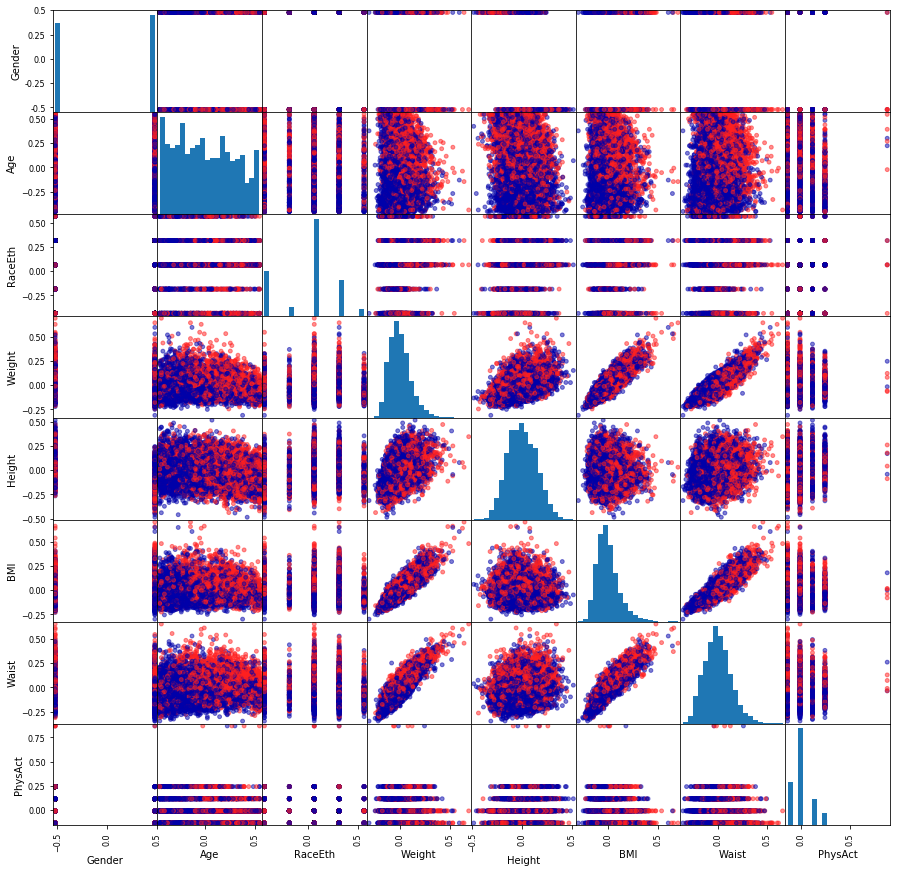

In [14]:
# create a scatter matrix from the dataframe, color by y
grr = pd.scatter_matrix(normalized_features, c=label, figsize=(15, 15), marker='.',
                        hist_kwds={'bins': 20}, s=60, alpha=.5, cmap=mglearn.cm2)

### Formatting input for Machine Learning

In [15]:
# X = features.as_matrix()
X = normalized_features.as_matrix()

Y = label.as_matrix()

print "Shape of the matrices"
print X.shape
print Y.shape

print "\n"
print "Total unique counts by labels"
print np.unique(Y, return_counts=True)

# Y = label_binarize(Y, classes=[0, 1])

# 70% training and 30% test 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# sm = SMOTE(random_state=42)

# x_train, y_train = sm.fit_sample(x_train, y_train)

print "\n"
print "Total unique counts by labels for training and testing"
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print np.unique(y_train, return_counts=True)
print np.unique(y_test, return_counts=True)

Shape of the matrices
(6296, 8)
(6296,)


Total unique counts by labels
(array([ 0.,  1.]), array([3710, 2586]))


Total unique counts by labels for training and testing
(4407, 'train sequences')
(1889, 'test sequences')
(array([ 0.,  1.]), array([2592, 1815]))
(array([ 0.,  1.]), array([1118,  771]))


#### Random Forest 
RF number of trees - 500


In [16]:
import itertools
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# These are the tuned paramters

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##### Training

In [80]:
clf = RandomForestClassifier(n_estimators=500, max_features=None, class_weight='balanced')

clf.fit(x_train, y_train)
predicted_labels = clf.predict(x_test)
label_test = np.array(y_test)

##### Accuracy Figures

In [81]:
result = {}
result['recall'] = recall_score(label_test, predicted_labels,
                                average='weighted')
result['accuracy'] = accuracy_score(label_test, predicted_labels)
result['precision'] = precision_score(label_test, predicted_labels,
                                      average='weighted')
target_names = ['Normal', 'Diabetic']

print result['accuracy'], result['precision'], result['recall']

print(classification_report(label_test, predicted_labels, target_names=target_names))

0.670195870831 0.668759320472 0.670195870831
             precision    recall  f1-score   support

     Normal       0.72      0.73      0.72      1118
   Diabetic       0.60      0.58      0.59       771

avg / total       0.67      0.67      0.67      1889



##### Confusion Matrix

Confusion matrix, without normalization
[[818 300]
 [323 448]]


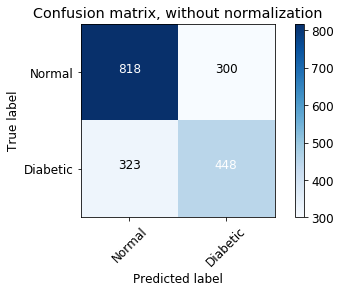

In [82]:
cnf_matrix = confusion_matrix(label_test, predicted_labels)
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')

##### More accuracy Figures

In [83]:
print "Accuracy TP/TN"
print((TP + TN) / float(TP + TN + FP + FN))

print '\n'
print "Classification error"
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print classification_error

print '\n'
print "Sensitivity / Recall"
sensitivity = TP / float(FN + TP)
print(sensitivity)

print '\n'
print "Specificity"
specificity = TN / float(TN + FP)
print(specificity)

print '\n'
print "False Positive Rate"
false_positive_rate = FP b/ float(TN + FP)
print(false_positive_rate)
print(1 - specificity)

print '\n'
print "Precision"
precision = TP / float(TP + FP)
print(precision)

Accuracy TP/TN
0.670195870831


Classification error
0.329804129169


Sensitivity / Recall
0.581063553826


Specificity
0.731663685152


False Positive Rate
0.268336314848
0.268336314848


Precision
0.598930481283


##### AUC ROC Curve

In [85]:
predict_proba = clf.predict_proba(x_test)

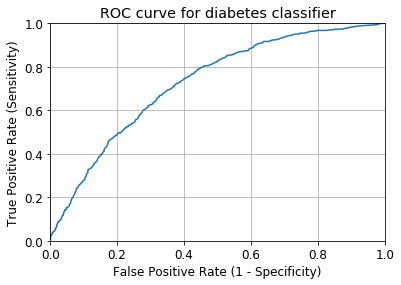

In [87]:
fpr, tpr, thresholds = roc_curve(label_test, predict_proba[:, 1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [88]:
print(roc_auc_score(y_test, y_pred_prob))

0.727301044806


##### Model Probabilities Check

In [41]:
clf.predict(x_test)[0:30]

array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.])

In [42]:
clf.predict_proba(x_test)[0:30]

array([[ 0.576,  0.424],
       [ 0.522,  0.478],
       [ 0.756,  0.244],
       [ 0.646,  0.354],
       [ 0.296,  0.704],
       [ 0.34 ,  0.66 ],
       [ 0.892,  0.108],
       [ 0.226,  0.774],
       [ 0.48 ,  0.52 ],
       [ 0.742,  0.258],
       [ 0.938,  0.062],
       [ 0.41 ,  0.59 ],
       [ 0.998,  0.002],
       [ 0.978,  0.022],
       [ 0.978,  0.022],
       [ 0.57 ,  0.43 ],
       [ 0.68 ,  0.32 ],
       [ 0.24 ,  0.76 ],
       [ 0.244,  0.756],
       [ 0.142,  0.858],
       [ 0.162,  0.838],
       [ 1.   ,  0.   ],
       [ 0.204,  0.796],
       [ 0.714,  0.286],
       [ 0.924,  0.076],
       [ 0.986,  0.014],
       [ 0.2  ,  0.8  ],
       [ 0.65 ,  0.35 ],
       [ 0.876,  0.124],
       [ 0.446,  0.554]])

In [43]:
y_test[0:30]

array([ 0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  1.])

In [44]:
# store the predicted probabilities for class 1
clf.predict_proba(x_test)[0:20, 1]

array([ 0.424,  0.478,  0.244,  0.354,  0.704,  0.66 ,  0.108,  0.774,
        0.52 ,  0.258,  0.062,  0.59 ,  0.002,  0.022,  0.022,  0.43 ,
        0.32 ,  0.76 ,  0.756,  0.858])

In [45]:
# store the predicted probabilities for class 1
y_pred_prob = clf.predict_proba(x_test)[:, 1]

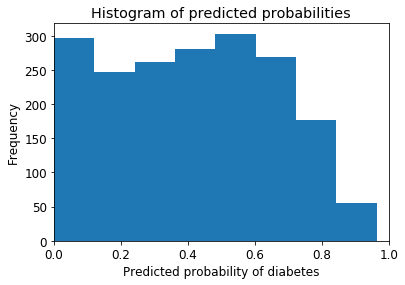

In [46]:
# adjust the font size 
plt.rcParams['font.size'] = 12


# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

##### Readjust Probability Decision to 0.3

In [98]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob, 0.30)[0]

/Users/somya/virtualenvs/ml/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [99]:
# print the first 10 predicted probabilities
y_pred_prob[0:20]

array([ 0.424,  0.478,  0.244,  0.354,  0.704,  0.66 ,  0.108,  0.774,
        0.52 ,  0.258,  0.062,  0.59 ,  0.002,  0.022,  0.022,  0.43 ,
        0.32 ,  0.76 ,  0.756,  0.858])

In [100]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:20]

array([ 1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.])

In [101]:
# new confusion matrix (threshold of 0.3)
print(confusion_matrix(y_test, y_pred_class))

[[542 576]
 [119 652]]


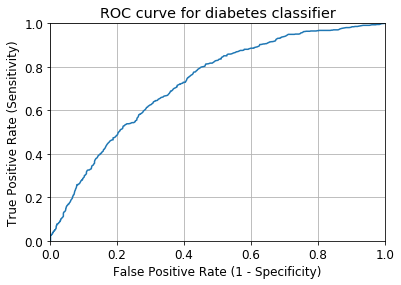

In [102]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [103]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [104]:
evaluate_threshold(0.5)

('Sensitivity:', 0.58236057068741898)
('Specificity:', 0.73076923076923084)


In [105]:
evaluate_threshold(0.3)

('Sensitivity:', 0.84565499351491569)
('Specificity:', 0.48479427549194987)


In [106]:
print(roc_auc_score(y_test, y_pred_prob))

0.727301044806
